## Packages and definition of parameters

In [1]:
# --- packages --- #
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import os, sys, glob
import matplotlib.colors as colors
from scipy.stats import binned_statistic_2d

from ctapipe.instrument import SubarrayDescription
from magicctapipe.utils import calculate_impact


# --- path to all scripts --- #
sys.path.insert(0, '/fefs/aswg/workspace/juan.jimenez/stereo_analysis/scripts')
import auxiliar as aux
import geometry as geom
# graphic parameters
aux.params()

# # -- image fitting limits [m] for the maps --- #
# ylim  = (-110, 110)
# xlim  = (-90,   90)

# --- paths --- #
dir_mask = '/fefs/aswg/LST1MAGIC/mc/DL2/ST0316A/NSB1.5/GammaTest/v01.2/dec_2276/*.h5'
event_coinc_dir   = '/fefs/aswg/workspace/juan.jimenez/data/dl1/joint_runs_magic_lst'
dir_stereo_reco   = '/fefs/aswg/workspace/juan.jimenez/data/datasets/'
name_stereo_3T    = 'stereo_data_3T'
name_stereo_total = 'stereo_data_total'

filenames = glob.glob(dir_mask)
filenames.sort()
print(f'{len(filenames)} MC files found')
for i,f in zip(range(len(filenames)),filenames):
    index1, index2 = f.find('/dl2_'), f.find(f'_LST-1_MAGIC_')
    f = f.replace('_', ' ')
    
# --- selecting file --- #
index_file = 7
print(f'\nThe file selected is:\n{filenames[index_file]}')

kw_txt = dict(ha='center', va='center')

67 MC files found

The file selected is:
/fefs/aswg/LST1MAGIC/mc/DL2/ST0316A/NSB1.5/GammaTest/v01.2/dec_2276/dl2_gamma_zd_32.059deg_az_136.05deg_LST-1_MAGIC_run104_to_50004.h5


In [2]:
###########################################
# --- telescopes positions extraction --- #
###########################################

tel_positions = SubarrayDescription.from_hdf(filenames[index_file]).positions

coord_t1, coord_t2, coord_t3 = [tel_positions[tel_index].value for tel_index in [1, 2, 3]]

xpos = np.array([tel_positions[i].value[0] for i in [1, 2, 3]])
ypos = np.array([tel_positions[i].value[1] for i in [1, 2, 3]])
zpos = np.array([tel_positions[i].value[2] for i in [1, 2, 3]])

# applying a 90 degree rotation to set the north in the y direction
xpos, ypos = ypos, xpos
xpos = xpos * (-1)

coord_t1 = [xpos[0], ypos[0], zpos[0]]
coord_t2 = [xpos[1], ypos[1], zpos[1]]
coord_t3 = [xpos[2], ypos[2], zpos[2]]

print(f'\nExtracting telescopes positions:')
print(f'LST-1   coords:  [{xpos[0]:.2f}, {ypos[0]:.2f}, {zpos[0]:.2f}] m')
print(f'MAGIC-1 coords:  [{xpos[1]:.2f}, {ypos[1]:.2f}, {zpos[1]:.2f}] m')
print(f'MAGIC-2 coords:  [{xpos[2]:.2f}, {ypos[2]:.2f}, {zpos[2]:.2f}] m')

###########################################

#####################################
# --- dataframes of MC analysis --- #
#####################################
print(f'\nReading .h5 file')
df   = pd.read_hdf(filenames[index_file], key='/events/parameters').query(f'combo_type == 3 & tel_id == 1')
dfT1 = pd.read_hdf(filenames[index_file], key='/events/parameters').query(f'combo_type == 3 & tel_id == 1')
dfT2 = pd.read_hdf(filenames[index_file], key='/events/parameters').query(f'combo_type == 3 & tel_id == 2')
dfT3 = pd.read_hdf(filenames[index_file], key='/events/parameters').query(f'combo_type == 3 & tel_id == 3')

# --- dropping non useful columns of the df --- #
del_cols = ['obs_id', 'event_id', 'tel_id', 'n_pixels', 'n_islands', 'magic_stereo', 'intensity', 'skewness',
            'kurtosis', 'x', 'y', 'r', 'length', 'length_uncertainty', 'width', 'width_uncertainty', 
            'intercept', 'deviation', 'slope', 'pixels_width_1', 'pixels_width_2', 'intensity_width_1',
            'intensity_width_2', 'multiplicity', 'combo_type', 'alt_uncert', 'az_uncert', 'true_disp', 
            'off_axis', 'reco_energy_var', 'reco_disp', 'reco_disp_var', 'disp_diff_sum', 'disp_diff_mean',
            'gammaness_var', 'impact', 'true_impact']

df   = df.drop(  del_cols,      axis=1)
dfT1 = dfT1.drop(del_cols[:-2], axis=1)
dfT2 = dfT2.drop(del_cols[:-2], axis=1)
dfT3 = dfT3.drop(del_cols[:-2], axis=1)
#####################################

display(df.head(5))


Extracting telescopes positions:
LST-1   coords:  [-77.13, -8.09, 0.78] m
MAGIC-1 coords:  [62.55, 39.30, -0.97] m
MAGIC-2 coords:  [14.57, -31.21, 0.20] m

Reading .h5 file


,pointing_alt,pointing_az,true_energy,true_alt,true_az,true_core_x,true_core_y,phi,psi,alt,az,core_x,core_y,h_max,reco_energy,reco_alt,reco_az,gammaness
0,1.011261,2.374573,0.142300,57.980451,136.800370,55.961494,18.880577,39.330005,-46.729343,56.323353,139.351368,519.688134,84.264622,10209.929342,0.177353,57.669253,136.666424,0.876667
3,1.011261,2.374573,0.142300,57.980451,136.800370,66.290764,94.369255,41.407601,-44.334405,58.022161,137.222958,57.778199,60.309566,11386.728429,0.186783,57.999677,137.070784,0.882667
8,1.011261,2.374573,0.116151,57.562027,135.810402,-42.082085,14.901803,-166.756243,12.325916,57.698054,135.942125,-63.222631,-1.132751,8670.409788,0.129053,57.647729,135.908197,0.893333
11,1.011261,2.374573,0.207810,57.617557,135.608379,-54.150646,-117.012306,-145.208063,27.763891,57.698210,135.540995,-70.055052,-123.384813,11739.645931,0.182691,57.615533,135.433076,0.995000
16,1.011261,2.374573,0.118614,57.574622,135.749586,116.045456,92.986481,-71.148210,-26.425450,57.414663,135.677535,134.736517,136.540374,10663.680305,0.120659,57.518007,135.627135,0.966667


In [3]:
# --- changing the coordinates --- #

############################################
# --------------- angles ----------------- #
############################################
# extracting pointing direction #
# changing from alt to zd
# changing to az to angle in spherical coordinates
point_zd       = 90 - np.rad2deg(df['pointing_alt'].to_numpy()[0])
point_eq_angle = - np.rad2deg(df['pointing_az'].to_numpy()[0]) + 90
point_az       =   np.rad2deg(df['pointing_az'].to_numpy()[0])

df['pointing_zd']       = point_zd 
df['pointing_eq_angle'] = point_eq_angle
df['pointing_az']       = point_az

point_dir = (point_zd, point_eq_angle)
print(f'The pointing direction is zd = {point_zd:.2f}deg and az = {point_az:.2f}deg')

# reconstructed directions
zd = 90 - df['reco_alt'].to_numpy()
eq_angle = - df['reco_az'].to_numpy() + 90
df['reco_zd'] = zd
df['reco_eq_angle'] = eq_angle

# true directions
true_zd = 90 - df['true_alt'].to_numpy()
true_eq_angle = - df['true_az'].to_numpy() + 90
df['true_zd'] = true_zd
df['true_eq_angle'] = true_eq_angle

############################################

############################################
# -------------- positions --------------- #
############################################

# reconstructed core positions
df['core_x'], df['core_y'] = df['core_y'], df['core_x']
df['core_x'] = df['core_x'].to_numpy() * (-1)

core_x = df['core_x'].to_numpy()
core_y = df['core_y'].to_numpy()
core_z = np.zeros(len(core_x))
df['core_z'] = core_z

# true cores positions
df['true_core_x'], df['true_core_y'] = df['true_core_y'], df['true_core_x']
df['true_core_x'] = df['true_core_x'].to_numpy() * (-1)

true_core_x = df['true_core_x'].to_numpy()
true_core_y = df['true_core_y'].to_numpy()
true_core_z = np.zeros(len(true_core_x))
df['true_core_z'] = true_core_z

# altitude of maximum intensity
h_max = df['h_max'].to_numpy()
############################################

############################################
# ----------- reference points ----------- #
############################################
# reference point for the plane of the telescopes
ref_lower = np.array([0, 0, 0])
# reference point in the mean(h_max) altitude
ref_upper = geom.z_projection(*ref_lower, *point_dir, np.mean(h_max))

print(f'\nRef point for lower plane is [{ref_lower[0]:.1f}, {ref_lower[1]:.1f}, {ref_lower[2]:.1f}]m')
print(f'Ref point for upper plane is [{ref_upper[0]:.1f}, {ref_upper[1]:.1f}, {ref_upper[2]:.1f}]m')
############################################

##################################
# --- telescopes projections --- #
##################################
print(f'\nCalculating the telescope projection in the different planes...')
positions_sets = [[xpos[i], ypos[i], zpos[i]] for i in range(len(xpos))]
t1_lower = geom.plane_projection(ref_lower, point_dir, *positions_sets[0], point_zd, point_eq_angle)
t1_upper = geom.plane_projection(ref_upper, point_dir, *positions_sets[0], point_zd, point_eq_angle)
t2_lower = geom.plane_projection(ref_lower, point_dir, *positions_sets[1], point_zd, point_eq_angle)
t2_upper = geom.plane_projection(ref_upper, point_dir, *positions_sets[1], point_zd, point_eq_angle)
t3_lower = geom.plane_projection(ref_lower, point_dir, *positions_sets[2], point_zd, point_eq_angle)
t3_upper = geom.plane_projection(ref_upper, point_dir, *positions_sets[2], point_zd, point_eq_angle)
xpos_lower, xpos_upper = [t1_lower[0], t2_lower[0], t3_lower[0]], [t1_upper[0], t2_upper[0], t3_upper[0]]
ypos_lower, ypos_upper = [t1_lower[1], t2_lower[1], t3_lower[1]], [t1_upper[1], t2_upper[1], t3_upper[1]]
zpos_lower, zpos_upper = [t1_lower[2], t2_lower[2], t3_lower[2]], [t1_upper[2], t2_upper[2], t3_upper[2]]
##################################

###################################################
# --- calculating plane projections of points --- #
###################################################
print('\nProjecting the points in the planes...')
cores_set      = [core_x, core_y, core_z]
true_cores_set = [true_core_x, true_core_y, true_core_z]
dirs_set       = [zd, eq_angle]
true_dirs_set  = [true_zd, true_eq_angle]

# calculating the projections
proj_set   = geom.plane_projection(ref_lower, point_dir, *cores_set, *point_dir)
lower_set  = geom.plane_projection(ref_lower, point_dir, *cores_set, *dirs_set)
upper_set  = geom.plane_projection(ref_upper, point_dir, *cores_set, *dirs_set)
shower_set = geom.z_projection(*cores_set, *dirs_set, h_max)
true_proj_set  = geom.plane_projection(ref_lower, point_dir, *true_cores_set, *point_dir)
true_lower_set = geom.plane_projection(ref_lower, point_dir, *true_cores_set, *true_dirs_set)
true_upper_set = geom.plane_projection(ref_upper, point_dir, *true_cores_set, *true_dirs_set)

# saving it into the total dataframe
df['proj_x'],   df['proj_y'],   df['proj_z']   = proj_set
df['lower_x'],  df['lower_y'],  df['lower_z']  = lower_set
df['upper_x'],  df['upper_y'],  df['upper_z']  = upper_set
df['shower_x'], df['shower_y'], df['shower_z'] = shower_set
df['true_proj_x'],  df['true_proj_y'],  df['true_proj_z']  = true_proj_set
df['true_lower_x'], df['true_lower_y'], df['true_lower_z'] = true_lower_set
df['true_upper_x'], df['true_upper_y'], df['true_upper_z'] = true_upper_set

# saving it to individual variables
proj_x,   proj_y,   proj_z   = proj_set
lower_x,  lower_y,  lower_z  = lower_set
upper_x,  upper_y,  upper_z  = upper_set
shower_x, shower_y, shower_z = shower_set
true_proj_x,  true_proj_y,  true_proj_z  = true_proj_set
true_lower_x, true_lower_y, true_lower_z = true_lower_set
true_upper_x, true_upper_y, true_upper_z = true_upper_set
###################################################

#########################################
# ------- calculating distances ------- #
#########################################
print('\nCalculating distances...')
df['dist_core']  = geom.dist3d(*cores_set, *true_cores_set)
df['dist_proj']  = geom.dist3d(*proj_set,  *true_proj_set)
df['dist_lower'] = geom.dist3d(*lower_set, *true_lower_set)
df['dist_upper'] = geom.dist3d(*upper_set, *true_upper_set)
#########################################

######################################################
# --- recalculating and adding impact parameters --- #
######################################################
print('\nCalculating impact parameters...')
for tel, dataframe, coord in zip(['1', '2', '3'], [dfT1, dfT2, dfT3], [coord_t1, coord_t2, coord_t3]):
    df[f'impact_{tel}']            = dataframe['impact'].to_numpy()
    df[f'true_impact_{tel}']       = dataframe['true_impact'].to_numpy()
    
    df[f'recal_impact_{tel}']      = geom.line_point_distance(*cores_set,      *dirs_set,      coord)
    df[f'recal_true_impact_{tel}'] = geom.line_point_distance(*true_cores_set, *true_dirs_set, coord)
    
    df[f'error_impact_A_{tel}'] = np.array(df[f'true_impact_{tel}']       - df[f'impact_{tel}'])  
    df[f'error_impact_B_{tel}'] = np.array(df[f'recal_true_impact_{tel}'] - df[f'recal_impact_{tel}'])
    df[f'error_impact_C_{tel}'] = np.array(df[f'recal_impact_{tel}']      - df[f'impact_{tel}'])    
    df[f'error_impact_D_{tel}'] = np.array(df[f'recal_true_impact_{tel}'] - df[f'true_impact_{tel}'])
######################################################

####################################
# --- calculating other errors --- #
####################################
df['error_zd'] = df['true_zd'] - df['reco_zd']
df['error_az'] = df['true_az'] - df['reco_az']
####################################

# deleting redundant variables
del cores_set,      proj_set,      lower_set,      upper_set,      dirs_set,     shower_set
del true_cores_set, true_proj_set, true_lower_set, true_upper_set, true_dirs_set
del positions_sets

display(df.head(5))

The pointing direction is zd = 32.06deg and az = 136.05deg

Ref point for lower plane is [0.0, 0.0, 0.0]m
Ref point for upper plane is [4921.6, -5106.0, 11323.3]m

Calculating the telescope projection in the different planes...

Projecting the points in the planes...

Calculating distances...

Calculating impact parameters...


,pointing_alt,pointing_az,true_energy,true_alt,true_az,true_core_x,true_core_y,phi,psi,alt,az,core_x,core_y,h_max,reco_energy,reco_alt,reco_az,gammaness,pointing_zd,pointing_eq_angle,reco_zd,reco_eq_angle,true_zd,true_eq_angle,core_z,true_core_z,proj_x,proj_y,proj_z,lower_x,lower_y,lower_z,upper_x,upper_y,upper_z,shower_x,shower_y,shower_z,true_proj_x,true_proj_y,true_proj_z,true_lower_x,true_lower_y,true_lower_z,true_upper_x,true_upper_y,true_upper_z,dist_core,dist_proj,dist_lower,dist_upper,impact_1,true_impact_1,recal_impact_1,recal_true_impact_1,error_impact_A_1,error_impact_B_1,error_impact_C_1,error_impact_D_1,impact_2,true_impact_2,recal_impact_2,recal_true_impact_2,error_impact_A_2,error_impact_B_2,error_impact_C_2,error_impact_D_2,impact_3,true_impact_3,recal_impact_3,recal_true_impact_3,error_impact_A_3,error_impact_B_3,error_impact_C_3,error_impact_D_3,error_zd,error_az
0,1.011261,136.052994,0.142300,57.980451,136.800370,-18.880577,55.961494,39.330005,-46.729343,56.323353,139.351368,-84.264622,519.688134,10209.929342,0.177353,57.669253,136.666424,0.876667,32.059002,-46.052994,32.330747,-46.666424,32.019549,-46.800370,0.0,0.0,0.328676,431.926912,194.624330,0.019071,430.353398,194.049361,4903.647988,-4767.145476,11483.849709,4350.331493,-4180.669235,10209.929342,-8.440622,45.130575,24.019270,-8.593862,45.007114,24.030204,4840.806874,-5119.146972,11352.436826,468.313431,422.840861,421.274797,380.950659,477.342242,73.328913,484.865487,86.472727,-404.013329,-398.392760,7.523245,13.143814,433.181447,86.150210,441.317832,75.319559,-347.031237,-365.998274,8.136385,-10.830652,491.557594,78.703033,500.386527,81.252395,-412.854560,-419.134132,8.828933,2.549361,-0.311198,0.133946
3,1.011261,136.052994,0.142300,57.980451,136.800370,-94.369255,66.290764,41.407601,-44.334405,58.022161,137.222958,-60.309566,57.778199,11386.728429,0.186783,57.999677,137.070784,0.882667,32.059002,-46.052994,32.000323,-47.070784,32.019549,-46.800370,0.0,0.0,-43.992219,40.849786,37.541422,-44.320968,40.590002,37.567169,4778.163689,-5143.717699,11368.585046,4785.885518,-5152.018884,11386.728429,-72.231873,43.324361,50.931614,-72.556811,43.062569,50.954799,4776.843925,-5121.091516,11379.361420,35.107352,31.351217,31.346532,25.096138,64.910781,63.117558,64.932003,67.515801,-1.793222,2.583798,0.021223,4.398243,113.501745,155.558093,113.438592,144.650101,42.056348,31.211510,-0.063153,-10.907992,98.592783,128.465640,98.573562,124.037732,29.872857,25.464169,-0.019220,-4.427908,0.019226,-0.270414
8,1.011261,136.052994,0.116151,57.562027,135.810402,-14.901803,-42.082085,-166.756243,12.325916,57.698054,135.942125,1.132751,-63.222631,8670.409788,0.129053,57.647729,135.908197,0.893333,32.059002,-46.052994,32.352271,-45.908197,32.437973,-45.810402,0.0,0.0,-7.921127,-53.829696,-20.830313,-8.019032,-53.776020,-20.763554,4966.843448,-5188.905724,11266.199083,3822.718569,-4007.922394,8670.409788,-18.803834,-38.033927,-8.977427,-18.862339,-38.007897,-8.940259,4976.572118,-5176.792211,11267.432826,26.533556,22.548404,22.494473,15.585453,81.883269,55.642387,81.837293,61.275901,-26.240882,-20.561392,-0.045977,5.633514,118.248053,125.478838,118.250117,112.308888,7.230785,-5.941229,0.002064,-13.169951,33.979665,43.937154,33.979641,30.626125,9.957490,-3.353516,-0.000024,-13.311030,0.085702,-0.097795
11,1.011261,136.052994,0.207810,57.617557,135.608379,117.012306,-54.150646,-145.208063,27.763891,57.698210,135.540995,123.384813,-70.055052,11739.645931,0.182691,57.615533,135.433076,0.995000,32.059002,-46.052994,32.384467,-45.433076,32.382443,-45.608379,0.0,0.0,96.780290,-42.454220,-61.209193,96.238776,-42.495510,-60.992443,5118.056693,-5140.808894,11222.162500,5348.374152,-5374.634691,11739.645931,93.511435,-29.769694,-54.068602,93.109220,-29.734476,-53.877899,5098.984481,-5143.061651,11229.436394,17.133563,14.918802,14.941715,20.536157,185.570031,168.557583,185.397380,178.226235,-17.012447,-7.171145,-0.172651,9.668652,106.751285,94.242818,106.682224,91.934447,-12.508467,-14.747


The plotting limits that will be used in the data:
xlims:[-1476.5,6398.1], ylims:[-8169.5,3063.6], zlims:[-41340.4,36234.4]

Masking the points within the limits...


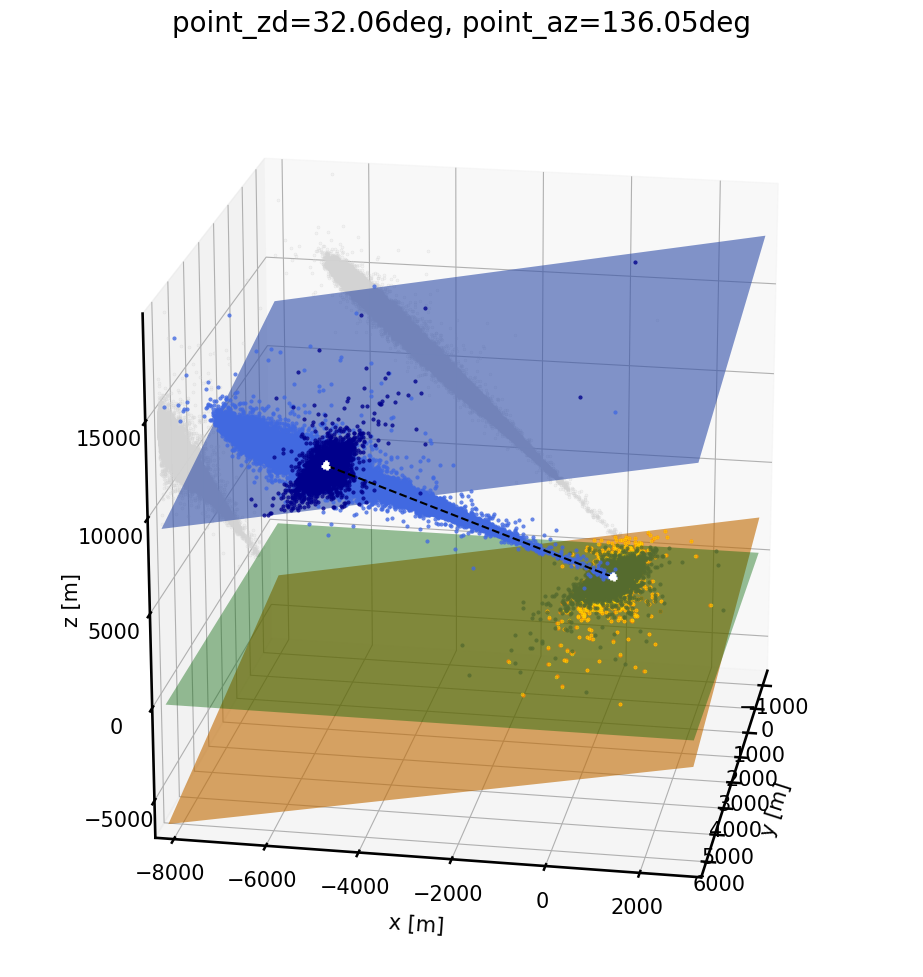

In [17]:
fig = plt.figure(figsize=(20,10))
fig.suptitle(f'point_zd={point_zd:.2f}deg, point_az={point_az:.2f}deg', fontsize=20)
ax  = fig.add_subplot(1, 1, 1, projection='3d') 

#####################################
# --- plot the reference points --- #
#####################################
ref_points = [[ref_lower[i], ref_upper[i]] for i in range(len(ref_lower))]
ax.plot(*ref_points,                        ls='--', c='k', marker='',  zorder=30, ms=4, lw=1.5, alpha=1)
ax.plot(xpos, ypos, zpos,                   ls='',   c='w', marker='+', zorder=30, ms=4, lw=2)
ax.plot(xpos_upper, ypos_upper, zpos_upper, ls='',   c='w', marker='+', zorder=30, ms=4, lw=2)
#####################################

###########################################
# --- finding the limits for the plot --- #
###########################################
# finding the limits for a given sigma
sigmas_plot = [.3, .6, 3.2]
lims = aux.lim_plot(ref_lower, ref_upper, factor=sigmas_plot)
xmin, xmax, ymin, ymax, zmin, zmax = lims

print(f'\nThe plotting limits that will be used in the data:')
print(f'xlims:[{xmin:.1f},{xmax:.1f}], ylims:[{ymin:.1f},{ymax:.1f}], zlims:[{zmin:.1f},{zmax:.1f}]')

# setting the limits in x and y
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
###########################################

#############################
# --- create the planes --- #
#############################
# x & y points for the planes
n_points_plane = 2
x_range = np.linspace(xmin, xmax, n_points_plane)
y_range = np.linspace(ymin, ymax, n_points_plane)
X_grid,  Y_grid  = np.meshgrid(x_range, y_range)

# reference planes
core_plane   = geom.z_plane(X_grid, Y_grid, ref_lower, [0, 0])
perp_plane   = geom.z_plane(X_grid, Y_grid, ref_lower, point_dir)
source_plane = geom.z_plane(X_grid, Y_grid, ref_upper, point_dir)

# --- plot the planes --- #
ax.plot_surface(X_grid, Y_grid, perp_plane,   alpha=0.6, color='darkorange', zorder=-100)
ax.plot_surface(X_grid, Y_grid, core_plane,   alpha=0.4, color='green',      zorder=-50)
ax.plot_surface(X_grid, Y_grid, source_plane, alpha=0.6, color='royalblue',  zorder=-60)
#############################

###############################
# --- plotting the points --- #
###############################
# computing the needed masks for our limits
print(f'\nMasking the points within the limits...')
core_mask   = aux.mask_3d(core_x,   core_y,   core_z,   lims)
proj_mask   = aux.mask_3d(proj_x,   proj_y,   proj_z,   lims)
upper_mask  = aux.mask_3d(upper_x,  upper_y,  upper_z,  lims)
lower_mask  = aux.mask_3d(lower_x,  lower_y,  lower_z,  lims)
shower_mask = aux.mask_3d(shower_x, shower_y, shower_z, lims)

cores   = core_x[core_mask],     core_y[core_mask],     core_z[core_mask]
lowers  = lower_x[lower_mask],   lower_y[lower_mask],   lower_z[lower_mask]
projs   = proj_x[proj_mask],     proj_y[proj_mask],     proj_z[proj_mask]
uppers  = upper_x[upper_mask],   upper_y[upper_mask],   upper_z[upper_mask]
showers = shower_x[shower_mask], shower_y[shower_mask], shower_z[shower_mask]

# plotting the points
kw = dict(alpha=.8, ms=1)
ax.plot(*cores,   'o', color='darkolivegreen', **kw, zorder=6, label='core positions')
ax.plot(*lowers,  'o', color='darkorange',     **kw, zorder=4,  label='$\perp$-plane trajectory ext.')
ax.plot(*projs,   '.', color='gold',           **kw, zorder=5, label='$\perp$-plane projection')
ax.plot(*uppers,  'o', color='darkblue',       **kw, zorder=10, label='h_max plane trajectory ext.')
ax.plot(*showers, 'o', color='royalblue',      **kw, zorder=9,  label='h_max positions')

# plotting the projection in the axes
kw = dict(color='lightgray', alpha=0.5, ls='', marker='.', zorder=-20, ms=1)
ax.plot(np.zeros(len(showers[0])) + xmin, showers[1], showers[2], **kw)
ax.plot(showers[0], np.zeros(len(showers[1])) + ymin, showers[2], **kw)
###############################

##################
# --- others --- #
##################
ax.set_xlabel('y [m]')
ax.set_ylabel('x [m]')
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('z [m]', rotation=90)
ax.xaxis.labelpad = 5
ax.yaxis.labelpad = 10
ax.zaxis.labelpad = 17
ax.tick_params(axis='z', which='major', pad=10)
ax.tick_params(axis='x', rotation=0, which='major', pad=0)
fig.tight_layout()
ax.set_box_aspect([1,1,1])
##################

ax.view_init(20, 10)
plt.show()

# Checking sizes

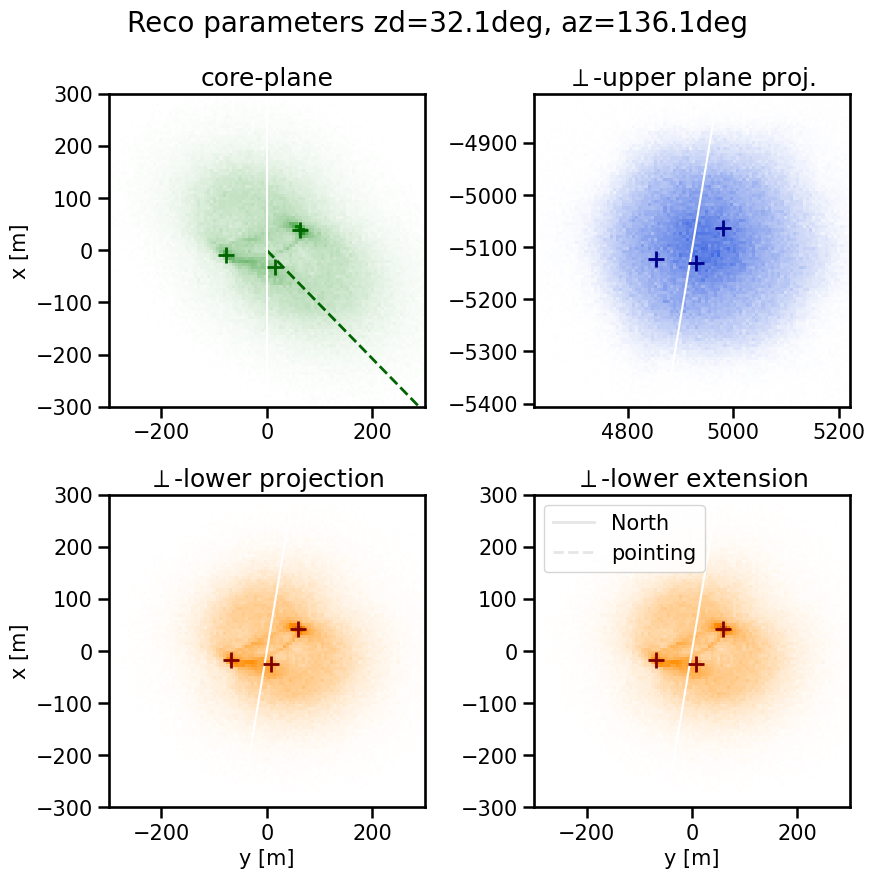

In [5]:
fig = plt.figure(figsize=(9, 9))
fig.suptitle(f'Reco parameters zd={point_zd:.1f}deg, az={point_az:.1f}deg', fontsize=20)
ax1 = fig.add_subplot(2, 2, 1) 
ax2 = fig.add_subplot(2, 2, 2) 
ax3 = fig.add_subplot(2, 2, 3) 
ax4 = fig.add_subplot(2, 2, 4) 

###################################
# --- plotting the histograms --- #
###################################
# creating colormaps
refscale = 300
ranges  = [[-refscale, refscale], [-refscale, refscale]]
ranges2 = [[ref_upper[0]-refscale, ref_upper[0]+refscale], [ref_upper[1]-refscale, ref_upper[1]+refscale]] 

cmapGreen = colors.LinearSegmentedColormap.from_list('',  ['w', 'g'])
cmapBlue = colors.LinearSegmentedColormap.from_list('',   ['w', 'royalblue'])
cmapOrange = colors.LinearSegmentedColormap.from_list('', ['w', 'darkorange','chocolate'])

# plotting histograms
Nbins = 100
ax1.hist2d(core_x,  core_y,  range=ranges,  bins=Nbins, cmap=cmapGreen)
ax2.hist2d(upper_x, upper_y, range=ranges2, bins=Nbins, cmap=cmapBlue)
ax3.hist2d(lower_x, lower_y, range=ranges,  bins=Nbins, cmap=cmapOrange)
ax4.hist2d(proj_x,  proj_y,  range=ranges,  bins=Nbins, cmap=cmapOrange)

###################################

#################################################
# --- plotting the telescopes in the planes --- #
#################################################
ax1.plot(xpos, ypos,             ls='', c='darkgreen', marker='+', zorder=30, ms=12, lw=2)
ax2.plot(xpos_upper, ypos_upper, ls='', c='darkblue',  marker='+', zorder=30, ms=12, lw=2)
ax3.plot(xpos_lower, ypos_lower, ls='', c='maroon',    marker='+', zorder=30, ms=12, lw=2)
ax4.plot(xpos_lower, ypos_lower, ls='', c='maroon',    marker='+', zorder=30, ms=12, lw=2)
#################################################

#######################################
# --- plotting the direction line --- #
#######################################
init_lower = ref_lower[:-1]
init_upper = ref_upper[:-1]
ax1.plot(*geom.line_in_direction(point_eq_angle, init_lower, ax1), ls='--', lw=2, c='darkgreen')
#######################################

############################
# --- projecting north --- #
############################
# calculating projection of north, 
north_point = [0, 1, 0]
proj_north = geom.plane_projection(ref_lower, point_dir, *north_point, *point_dir)

projected_point_dir = np.rad2deg(np.arctan2(proj_north[1], proj_north[0]))

dirs = [90, projected_point_dir, projected_point_dir, projected_point_dir]
for di, ax, init in zip(dirs, [ax1, ax2, ax3, ax4], [init_lower, init_upper, init_lower, init_lower]):
    ax.plot(*geom.line_in_direction(di      , init, ax), ls='-', lw=1.5, c='w')
    ax.plot(*geom.line_in_direction(di - 180, init, ax), ls='-', lw=1.5, c='w')
############################

##################
# --- others --- #
##################
ax4.plot([], [], '-',  color='0.9', lw=2, label='North')
ax4.plot([], [], '--', color='0.9', lw=2, label='pointing')
ax4.legend()
titles = ['core-plane', '$\perp$-upper plane proj.', '$\perp$-lower projection', '$\perp$-lower extension']
for axe, t in zip([ax1, ax2, ax3, ax4], titles):
    axe.set_title(t)
    
for axis1, axis2 in zip([ax3, ax4], [ax1, ax3]):
    axis1.set_xlabel('y [m]')
    axis2.set_ylabel('x [m]')
##################

fig.tight_layout()
plt.show()

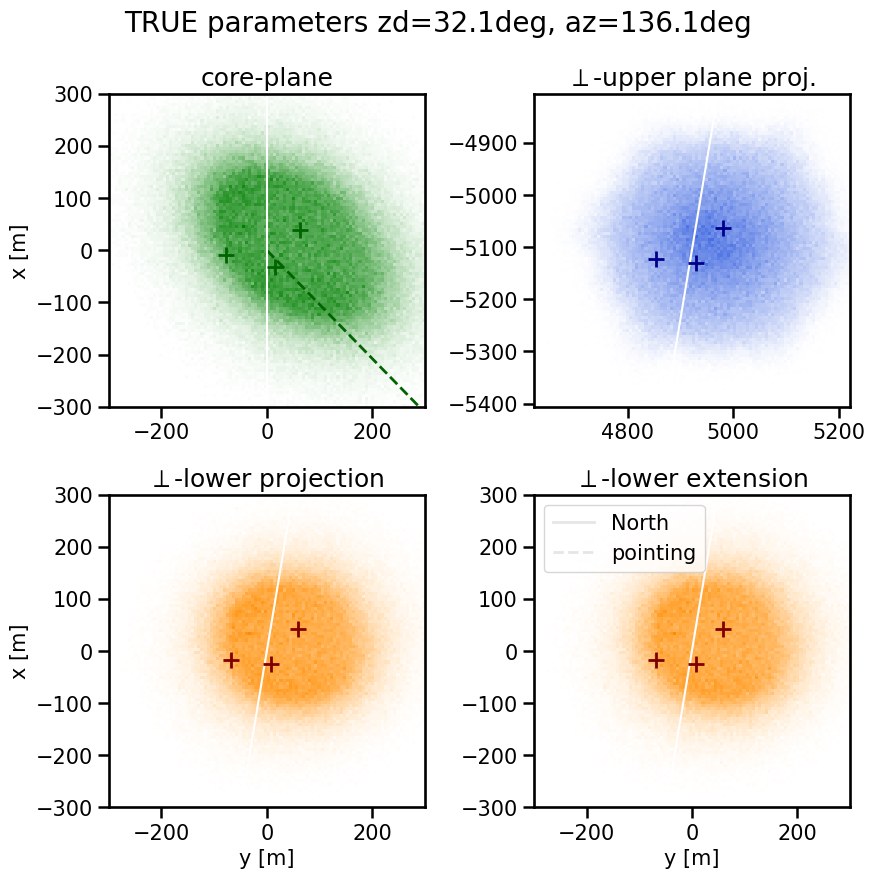

In [6]:
fig = plt.figure(figsize=(9, 9))
fig.suptitle(f'TRUE parameters zd={point_zd:.1f}deg, az={point_az:.1f}deg', fontsize=20)
ax1 = fig.add_subplot(2, 2, 1) 
ax2 = fig.add_subplot(2, 2, 2) 
ax3 = fig.add_subplot(2, 2, 3) 
ax4 = fig.add_subplot(2, 2, 4) 

###################################
# --- plotting the histograms --- #
###################################
# creating colormaps
refscale = 300
ranges  = [[-refscale, refscale], [-refscale, refscale]]
ranges2 = [[ref_upper[0]-refscale, ref_upper[0]+refscale], [ref_upper[1]-refscale, ref_upper[1]+refscale]] 

cmapGreen = colors.LinearSegmentedColormap.from_list('',  ['w', 'green'])
cmapBlue = colors.LinearSegmentedColormap.from_list('',   ['w', 'royalblue'])
cmapOrange = colors.LinearSegmentedColormap.from_list('', ['w', 'darkorange'])

# plotting histograms
Nbins = 100
ax1.hist2d(true_core_x,  true_core_y,  range=ranges,  bins=Nbins, cmap=cmapGreen)
ax2.hist2d(true_upper_x, true_upper_y, range=ranges2, bins=Nbins, cmap=cmapBlue)
ax3.hist2d(true_lower_x, true_lower_y, range=ranges,  bins=Nbins, cmap=cmapOrange)
ax4.hist2d(true_proj_x,  true_proj_y,  range=ranges,  bins=Nbins, cmap=cmapOrange)

###################################

#################################################
# --- plotting the telescopes in the planes --- #
#################################################
ax1.plot(xpos, ypos,             ls='', c='darkgreen', marker='+', zorder=30, ms=12, lw=2)
ax2.plot(xpos_upper, ypos_upper, ls='', c='darkblue',  marker='+', zorder=30, ms=12, lw=2)
ax3.plot(xpos_lower, ypos_lower, ls='', c='maroon',    marker='+', zorder=30, ms=12, lw=2)
ax4.plot(xpos_lower, ypos_lower, ls='', c='maroon',    marker='+', zorder=30, ms=12, lw=2)
#################################################

#######################################
# --- plotting the direction line --- #
#######################################
init_lower = ref_lower[:-1]
init_upper = ref_upper[:-1]
ax1.plot(*geom.line_in_direction(point_eq_angle, init_lower, ax1), ls='--', lw=2, c='darkgreen')
#######################################

############################
# --- projecting north --- #
############################
# calculating projection of north, 
north_point = [0, 1, 0]
proj_north = geom.plane_projection(ref_lower, point_dir, *north_point, *point_dir)

projected_point_dir = np.rad2deg(np.arctan2(proj_north[1], proj_north[0]))

dirs = [90, projected_point_dir, projected_point_dir, projected_point_dir]
for di, ax, init in zip(dirs, [ax1, ax2, ax3, ax4], [init_lower, init_upper, init_lower, init_lower]):
    ax.plot(*geom.line_in_direction(di      , init, ax), ls='-', lw=1.5, c='w')
    ax.plot(*geom.line_in_direction(di - 180, init, ax), ls='-', lw=1.5, c='w')
############################

##################
# --- others --- #
##################
ax4.plot([], [], '-',  color='0.9', lw=2, label='North')
ax4.plot([], [], '--', color='0.9', lw=2, label='pointing')
ax4.legend()
titles = ['core-plane', '$\perp$-upper plane proj.', '$\perp$-lower projection', '$\perp$-lower extension']
for axe, t in zip([ax1, ax2, ax3, ax4], titles):
    axe.set_title(t)
    
for axis1, axis2 in zip([ax3, ax4], [ax1, ax3]):
    axis1.set_xlabel('y [m]')
    axis2.set_ylabel('x [m]')
##################

fig.tight_layout()
plt.show()

## The distances in different planes

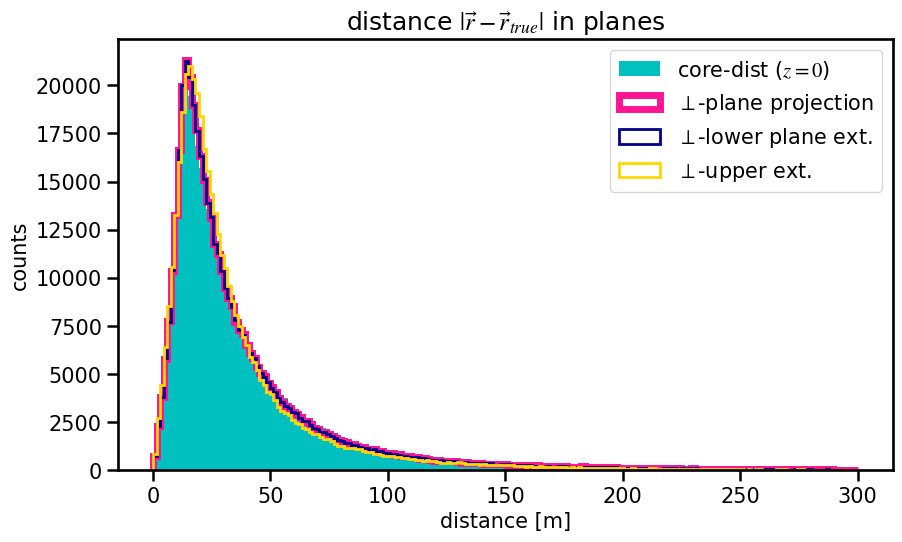

In [7]:
bins = np.linspace(0,300,200)

fig, ax = plt.subplots(figsize=(10,5.6))
ax.set_title('distance $|\\vec{r}-\\vec{r}_{true}|$ in planes')

lab = ['core-dist ($z=0$)', '$\perp$-plane projection', '$\perp$-lower plane ext.', '$\perp$-upper ext.']
ax.hist(df['dist_core'],  bins=bins, label=lab[0], histtype='stepfilled', color='c')
ax.hist(df['dist_proj'],  bins=bins, label=lab[1], histtype='step',       color='deeppink', lw=5)
ax.hist(df['dist_lower'], bins=bins, label=lab[2], histtype='step',       color='darkblue', lw=2)
ax.hist(df['dist_upper'], bins=bins, label=lab[3], histtype='step',       color='gold',     lw=2)

ax.legend()
ax.set_xlabel('distance [m]')
ax.set_ylabel('counts')
plt.show()

In [8]:
# --- binning the data in positions --- #
ylim  = (-110, 110)
xlim  = (-90,   90)

Nbins = 70
bins_x = np.linspace(*xlim, Nbins)
bins_y = np.linspace(*ylim, Nbins)

bins_x_center = (bins_x[:-1] + bins_x[1:]) / 2
bins_y_center = (bins_y[:-1] + bins_y[1:]) / 2

df['bin_x'] = pd.cut(df['core_x'], bins=bins_y, include_lowest=True)
df['bin_y'] = pd.cut(df['core_y'], bins=bins_x, include_lowest=True)

binned_zd  = [df.groupby(['bin_x', 'bin_y'])[f'{t}_zd'].mean().unstack().to_numpy().T for t in ['reco', 'true']]
binned_az  = [df.groupby(['bin_x', 'bin_y'])[f'{t}_az'].mean().unstack().to_numpy().T for t in ['reco', 'true']]
binned_err = [df.groupby(['bin_x', 'bin_y'])[f'error_{t}'].mean().unstack().to_numpy().T for t in ['zd', 'az']]

In [9]:
# --- binning the data in positions --- #
ylim  = (-110, 110)
xlim  = (-90,   90)

Nbins = 80
bins_x = np.linspace(*xlim, Nbins)
bins_y = np.linspace(*ylim, Nbins)
bins   = (bins_x, bins_y)
bins_x_center = (bins_x[:-1] + bins_x[1:]) / 2
bins_y_center = (bins_y[:-1] + bins_y[1:]) / 2

tcore_set  = [df['true_core_x'], df['true_core_y']]
core_set   = [df['core_x'], df['core_y']]

binned_zd  = [binned_statistic_2d(*core_set,  df[f'{t}_zd'],    bins=bins)[0].T for t in ['reco', 'true']]
binned_az  = [binned_statistic_2d(*tcore_set, df[f'{t}_az'],    bins=bins)[0].T for t in ['reco', 'true']]
binned_err = [binned_statistic_2d(*core_set,  df[f'error_{t}'], bins=bins)[0].T for t in ['zd', 'az']]

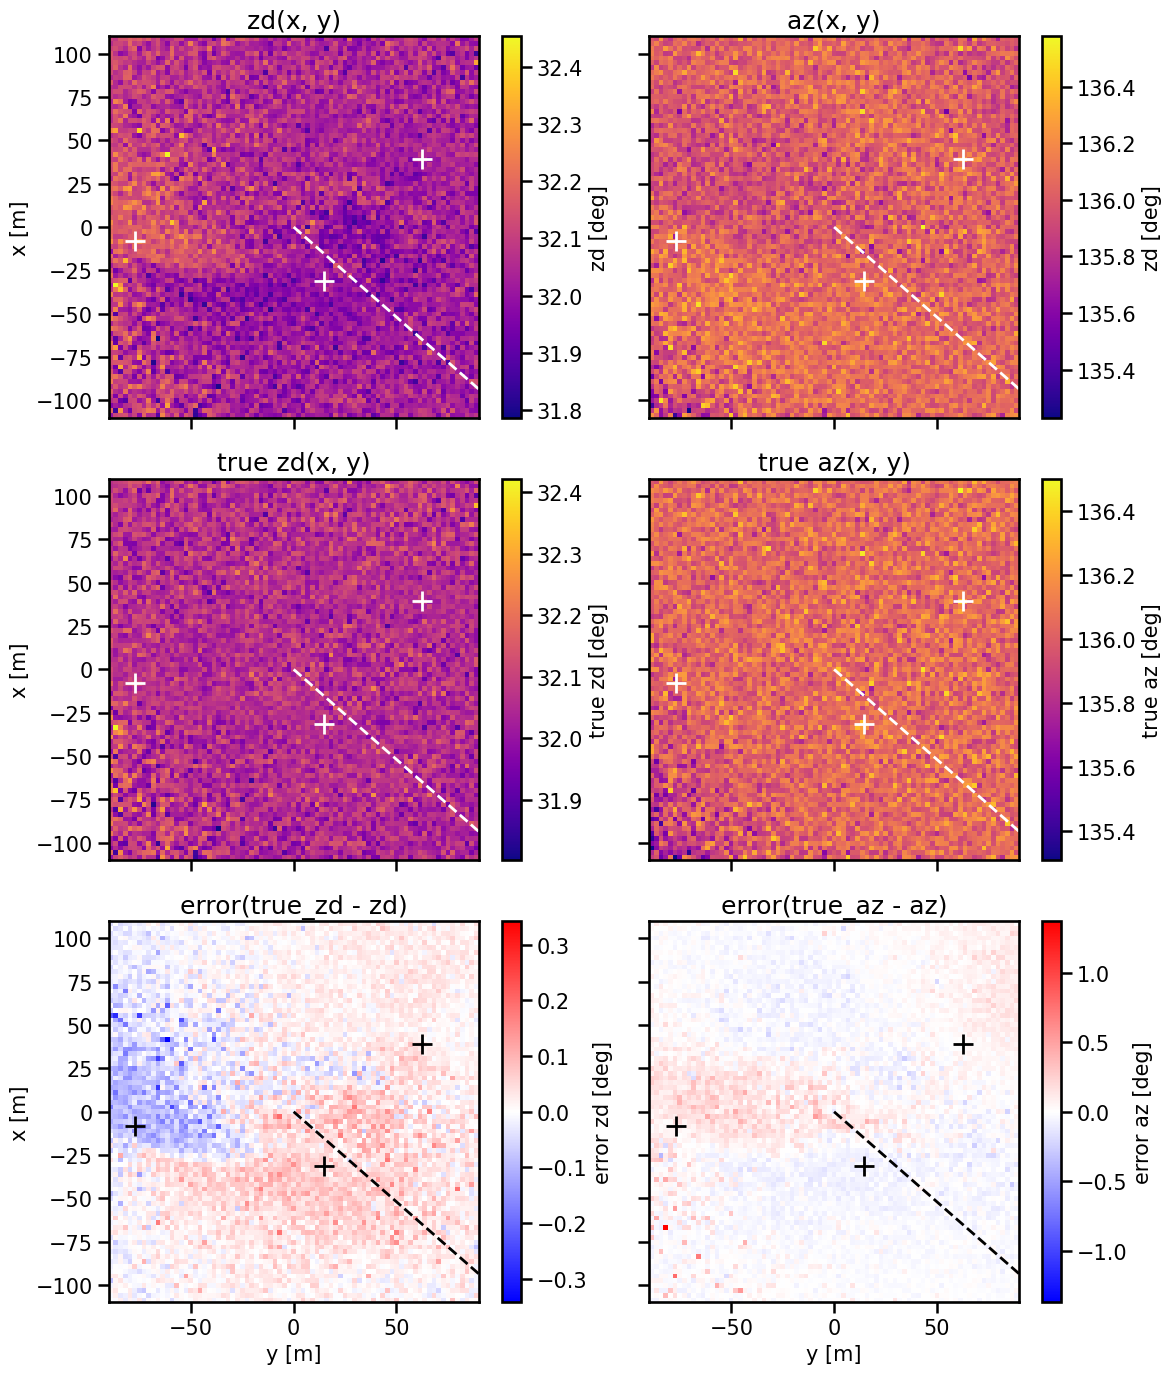

In [10]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12, 14), sharey=True, sharex=True)


# plot the binned data
cmesh = ax1.pcolormesh(bins_x_center, bins_y_center, binned_zd[0], cmap='plasma')
fig.colorbar(cmesh, ax=ax1, label=f'zd [deg]')
cmesh = ax2.pcolormesh(bins_x_center, bins_y_center, binned_az[0], cmap='plasma')
fig.colorbar(cmesh, ax=ax2, label=f'zd [deg]')
cmesh = ax3.pcolormesh(bins_x_center, bins_y_center, binned_zd[1], cmap='plasma')
fig.colorbar(cmesh, ax=ax3, label=f'true zd [deg]')
cmesh = ax4.pcolormesh(bins_x_center, bins_y_center, binned_az[1], cmap='plasma')
fig.colorbar(cmesh, ax=ax4, label=f'true az [deg]')

# errors
absmax = np.max([np.abs(np.nanmin(binned_err[0])), np.nanmax(binned_err[0])])
cmesh = ax5.pcolormesh(bins_x_center, bins_y_center, binned_err[0], cmap='bwr', vmax=absmax, vmin=-absmax)
fig.colorbar(cmesh, ax=ax5, label=f'error zd [deg]')
absmax = np.max([np.abs(np.nanmin(binned_err[1])), np.nanmax(binned_err[1])])
cmesh = ax6.pcolormesh(bins_x_center, bins_y_center, binned_err[1], cmap='bwr', vmax=absmax, vmin=-absmax)
fig.colorbar(cmesh, ax=ax6, label=f'error az [deg]')

#######################################
# --- plotting the direction line --- #
#######################################
init_lower = ref_lower[:-1]
init_upper = ref_upper[:-1]

# calculating projection of direction
ref_point = [np.cos(np.deg2rad(point_zd)) * np.sin(np.deg2rad(point_eq_angle)), np.sin(np.deg2rad(point_zd)) * np.sin(np.deg2rad(point_eq_angle)), np.cos(np.deg2rad(point_eq_angle))]
proj_ref = geom.plane_projection(ref_lower, point_dir, *ref_point, *point_dir)

projected_dir = np.rad2deg(np.arctan2(proj_ref[1], proj_ref[0]))

for ax in [ax1, ax2, ax3, ax4]:
    ax.plot(*geom.line_in_direction(point_eq_angle, init_lower, ax), ls='--', lw=2, c='w')
for ax in [ax5, ax6]:
    ax.plot(*geom.line_in_direction(point_eq_angle, init_lower, ax), ls='--', lw=2, c='k')
#######################################

titles = ['zd(x, y)','az(x, y)','true zd(x, y)','true az(x, y)']
for ax, t in zip([ax1, ax2, ax3, ax4, ax5, ax6], titles):
    ax.set_title(t)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.plot(xpos, ypos, ls='', c='w', marker='+', ms=15, lw=20)

for ax, t in zip([ax5, ax6], ['error(true_zd - zd)','error(true_az - az)']):
    ax.set_title(t)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.plot(xpos, ypos, ls='', c='k', marker='+', ms=15, lw=20)    
    
ax5.set_xlabel('y [m]')
ax6.set_xlabel('y [m]')
ax1.set_ylabel('x [m]')
ax3.set_ylabel('x [m]')
ax5.set_ylabel('x [m]')

fig.tight_layout()
plt.show()

## Plot other

,pointing_alt,pointing_az,true_energy,true_alt,true_az,true_core_x,true_core_y,phi,psi,alt,az,core_x,core_y,h_max,reco_energy,reco_alt,reco_az,gammaness,pointing_zd,pointing_eq_angle,reco_zd,reco_eq_angle,true_zd,true_eq_angle,core_z,true_core_z,proj_x,proj_y,proj_z,lower_x,lower_y,lower_z,upper_x,upper_y,upper_z,shower_x,shower_y,shower_z,true_proj_x,true_proj_y,true_proj_z,true_lower_x,true_lower_y,true_lower_z,true_upper_x,true_upper_y,true_upper_z,dist_core,dist_proj,dist_lower,dist_upper,impact_1,true_impact_1,recal_impact_1,recal_true_impact_1,error_impact_A_1,error_impact_B_1,error_impact_C_1,error_impact_D_1,impact_2,true_impact_2,recal_impact_2,recal_true_impact_2,error_impact_A_2,error_impact_B_2,error_impact_C_2,error_impact_D_2,impact_3,true_impact_3,recal_impact_3,recal_true_impact_3,error_impact_A_3,error_impact_B_3,error_impact_C_3,error_impact_D_3,error_zd,error_az,bin_x,bin_y
0,1.011261,136.052994,0.142300,57.980451,136.800370,-18.880577,55.961494,39.330005,-46.729343,56.323353,139.351368,-84.264622,519.688134,10209.929342,0.177353,57.669253,136.666424,0.876667,32.059002,-46.052994,32.330747,-46.666424,32.019549,-46.800370,0.0,0.0,0.328676,431.926912,194.624330,0.019071,430.353398,194.049361,4903.647988,-4767.145476,11483.849709,4350.331493,-4180.669235,10209.929342,-8.440622,45.130575,24.019270,-8.593862,45.007114,24.030204,4840.806874,-5119.146972,11352.436826,468.313431,422.840861,421.274797,380.950659,477.342242,73.328913,484.865487,86.472727,-404.013329,-398.392760,7.523245,13.143814,433.181447,86.150210,441.317832,75.319559,-347.031237,-365.998274,8.136385,-10.830652,491.557594,78.703033,500.386527,81.252395,-412.854560,-419.134132,8.828933,2.549361,-0.311198,0.133946,"(-84.493, -81.304]",NaN
3,1.011261,136.052994,0.142300,57.980451,136.800370,-94.369255,66.290764,41.407601,-44.334405,58.022161,137.222958,-60.309566,57.778199,11386.728429,0.186783,57.999677,137.070784,0.882667,32.059002,-46.052994,32.000323,-47.070784,32.019549,-46.800370,0.0,0.0,-43.992219,40.849786,37.541422,-44.320968,40.590002,37.567169,4778.163689,-5143.717699,11368.585046,4785.885518,-5152.018884,11386.728429,-72.231873,43.324361,50.931614,-72.556811,43.062569,50.954799,4776.843925,-5121.091516,11379.361420,35.107352,31.351217,31.346532,25.096138,64.910781,63.117558,64.932003,67.515801,-1.793222,2.583798,0.021223,4.398243,113.501745,155.558093,113.438592,144.650101,42.056348,31.211510,-0.063153,-10.907992,98.592783,128.465640,98.573562,124.037732,29.872857,25.464169,-0.019220,-4.427908,0.019226,-0.270414,"(-62.174, -58.986]","(56.087, 58.696]"
8,1.011261,136.052994,0.116151,57.562027,135.810402,-14.901803,-42.082085,-166.756243,12.325916,57.698054,135.942125,1.132751,-63.222631,8670.409788,0.129053,57.647729,135.908197,0.893333,32.059002,-46.052994,32.352271,-45.908197,32.437973,-45.810402,0.0,0.0,-7.921127,-53.829696,-20.830313,-8.019032,-53.776020,-20.763554,4966.843448,-5188.905724,11266.199083,3822.718569,-4007.922394,8670.409788,-18.803834,-38.033927,-8.977427,-18.862339,-38.007897,-8.940259,4976.572118,-5176.792211,11267.432826,26.533556,22.548404,22.494473,15.585453,81.883269,55.642387,81.837293,61.275901,-26.240882,-20.561392,-0.045977,5.633514,118.248053,125.478838,118.250117,112.308888,7.230785,-5.941229,0.002064,-13.169951,33.979665,43.937154,33.979641,30.626125,9.957490,-3.353516,-0.000024,-13.311030,0.085702,-0.097795,"(-1.594, 1.594]","(-63.913, -61.304]"
11,1.011261,136.052994,0.207810,57.617557,135.608379,117.012306,-54.150646,-145.208063,27.763891,57.698210,135.540995,123.384813,-70.055052,11739.645931,0.182691,57.615533,135.433076,0.995000,32.059002,-46.052994,32.384467,-45.433076,32.382443,-45.608379,0.0,0.0,96.780290,-42.454220,-61.209193,96.238776,-42.495510,-60.992443,5118.056693,-5140.808894,11222.162500,5348.374152,-5374.634691,11739.645931,93.511435,-29.769694,-54.068602,93.109220,-29.734476,-53.877899,5098.984481,-5143.061651,11229.436394,17.133563,14.918802,14.941715,20.536157,185.570031,168.557583,185.39

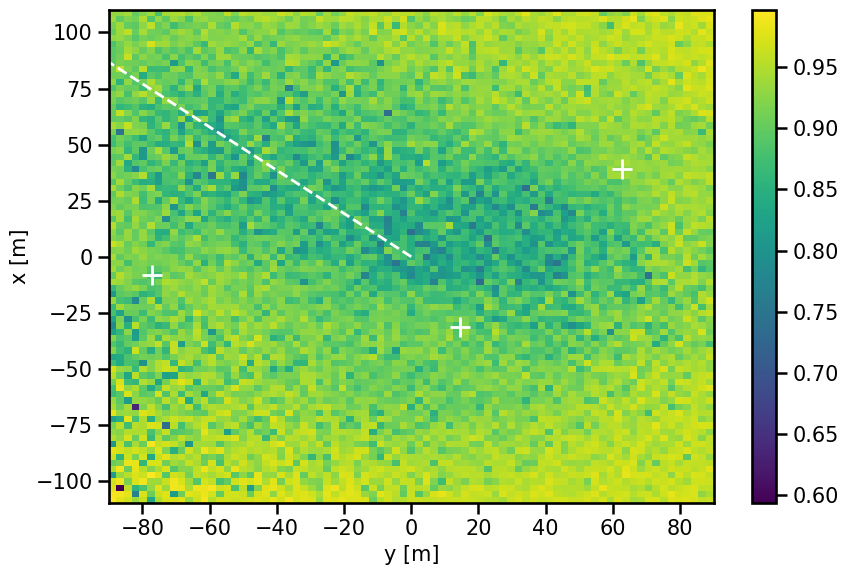

In [11]:
# --- binning the data in positions --- #
ylim  = (-110, 110)
xlim  = (-90,   90)

Nbins = 80
bins_x = np.linspace(*xlim, Nbins)
bins_y = np.linspace(*ylim, Nbins)
bins   = (bins_x, bins_y)
bins_x_center = (bins_x[:-1] + bins_x[1:]) / 2
bins_y_center = (bins_y[:-1] + bins_y[1:]) / 2

tcore_set  = [df['true_core_x'], df['true_core_y']]
core_set   = [df['core_x'], df['core_y']]

binned = binned_statistic_2d(*core_set,  df[f'gammaness'],    bins=bins)[0].T

display(df.head(5))

fig, ax = plt.subplots(figsize=(9, 6))

# plot the binned data
cmesh1 = ax.pcolormesh(bins_x_center, bins_y_center, binned, cmap='viridis')
fig.colorbar(cmesh1, ax=ax, label='')

ax.set_xlim(*xlim)
ax.set_ylim(*ylim)
ax.plot(xpos, ypos, ls='', c='w', marker='+', ms=15, lw=20)

# plotting directions
init_lower = ref_lower[:-1]
init_upper = ref_upper[:-1]
ax.plot(*geom.line_in_direction(point_az, init_lower, ax), ls='--', lw=2, c='w')

ax.set_xlabel('y [m]')
ax.set_ylabel('x [m]')

fig.tight_layout()
plt.show()

## Psi and phi parameters

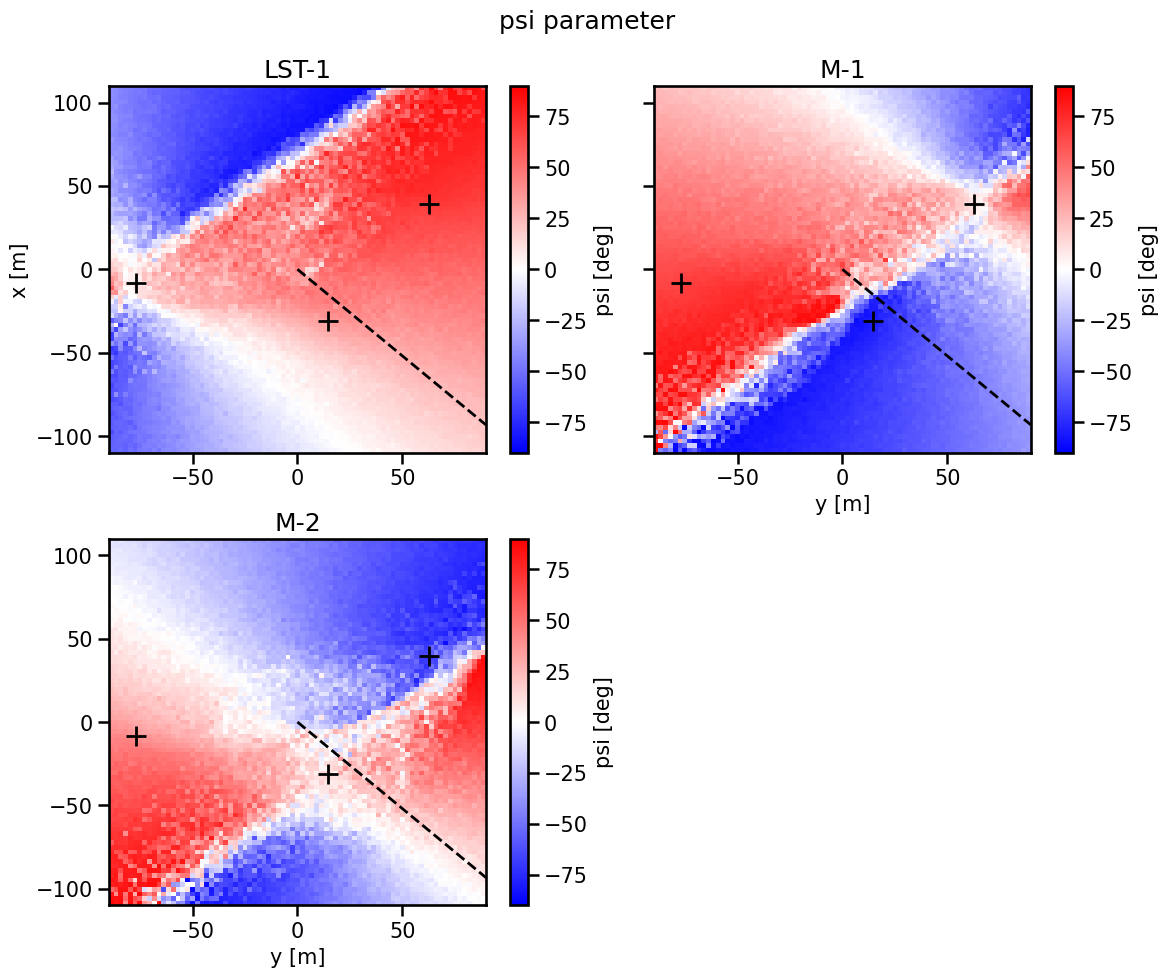

In [12]:
# --- binning the data in positions --- #
ylim  = (-110, 110)
xlim  = (-90,   90)

Nbins = 80
bins_x = np.linspace(*xlim, Nbins)
bins_y = np.linspace(*ylim, Nbins)
bins   = (bins_x, bins_y)
bins_x_center = (bins_x[:-1] + bins_x[1:]) / 2
bins_y_center = (bins_y[:-1] + bins_y[1:]) / 2

tcore_set  = [df['true_core_x'], df['true_core_y']]
core_set   = [df['core_x'], df['core_y']]

binned_1  = binned_statistic_2d(*core_set, df[f'psi'],   bins=bins)[0].T
binned_2  = binned_statistic_2d(*core_set, dfT2[f'psi'], bins=bins)[0].T
binned_3  = binned_statistic_2d(*core_set, dfT3[f'psi'], bins=bins)[0].T


fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
fig.suptitle('psi parameter')

# plot the binned data
absmax = 90
cmesh = ax1.pcolormesh(bins_x_center, bins_y_center, binned_1, cmap='bwr', vmax=absmax, vmin=-absmax)
fig.colorbar(cmesh, ax=ax1, label='psi [deg]')

absmax = 90
cmesh = ax2.pcolormesh(bins_x_center, bins_y_center, binned_2, cmap='bwr', vmax=absmax, vmin=-absmax)
fig.colorbar(cmesh, ax=ax2, label='psi [deg]')

absmax = 90
cmesh = ax3.pcolormesh(bins_x_center, bins_y_center, binned_3, cmap='bwr', vmax=absmax, vmin=-absmax)
fig.colorbar(cmesh, ax=ax3, label='psi [deg]')

#######################################
# --- plotting the direction line --- #
#######################################
init_lower = ref_lower[:-1]
init_upper = ref_upper[:-1]

# calculating projection of direction
ref_point = [np.cos(np.deg2rad(point_zd)) * np.sin(np.deg2rad(point_eq_angle)), np.sin(np.deg2rad(point_zd)) * np.sin(np.deg2rad(point_eq_angle)), np.cos(np.deg2rad(point_eq_angle))]
proj_ref = geom.plane_projection(ref_lower, point_dir, *ref_point, *point_dir)

projected_dir = np.rad2deg(np.arctan2(proj_ref[1], proj_ref[0]))

for ax in [ax1, ax2, ax3]:
    ax.plot(*geom.line_in_direction(point_eq_angle, init_lower, ax), ls='--', lw=2, c='k')
#######################################

for ax, t in zip([ax1, ax2, ax3],  ['LST-1', 'M-1', 'M-2']):
    ax.set_title(t)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.plot(xpos, ypos, ls='', c='k', marker='+', ms=15, lw=20) 
    
ax3.set_xlabel('y [m]')
ax2.set_xlabel('y [m]')
ax1.set_ylabel('x [m]')
fig.delaxes(ax4)

fig.tight_layout()
plt.show()

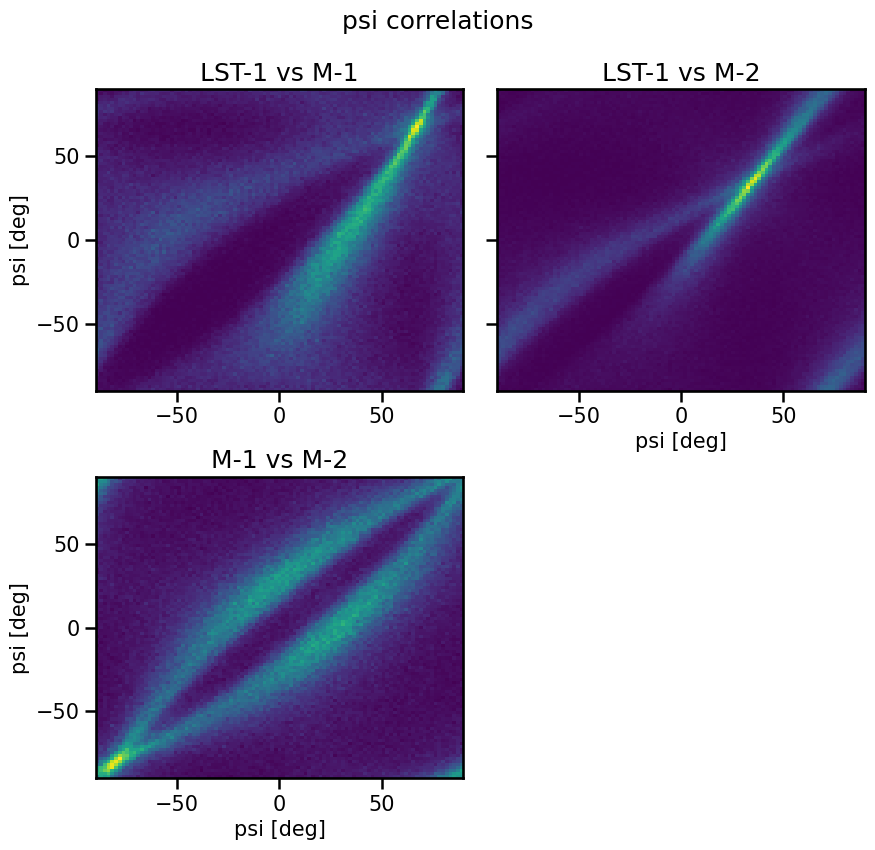

In [13]:
bins_x = np.linspace(-90, 90, 100)
bins_y = np.linspace(-90, 90, 100)
bins   = (bins_x, bins_y)


fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 8.7), sharey=True)
fig.suptitle('psi correlations')

ax1.hist2d(df[f'psi'], dfT2[f'psi'], bins=bins)
ax1.set_title(f'LST-1 vs M-1')

ax2.hist2d(df[f'psi'], dfT3[f'psi'], bins=bins)
ax2.set_title(f'LST-1 vs M-2')

ax3.hist2d(dfT2[f'psi'], dfT3[f'psi'], bins=bins)
ax3.set_title(f'M-1 vs M-2')

ax2.set_xlabel(f'psi [deg]')
ax3.set_xlabel(f'psi [deg]')
ax1.set_ylabel(f'psi [deg]')
ax3.set_ylabel(f'psi [deg]')
fig.delaxes(ax4)

fig.tight_layout()
plt.show()

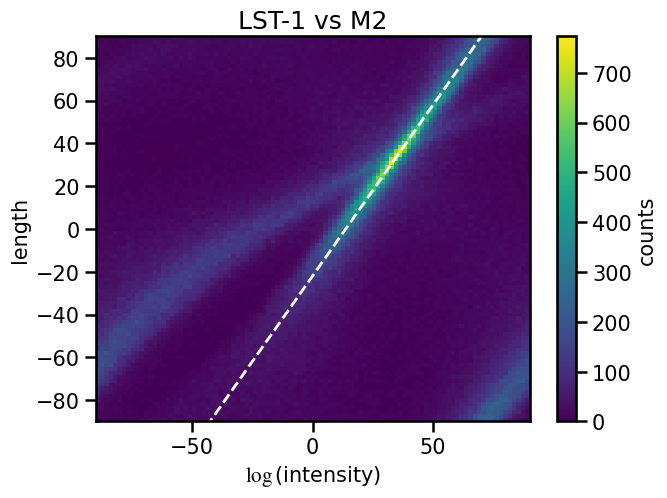

In [14]:
def line(x, slope, yint):
    return yint + slope * x

fig, ax = plt.subplots(figsize=(7,5))
ax.set_title(f'LST-1 vs M2')

bins_x = np.linspace(-90, 90, 100)
bins_y = np.linspace(-90, 90, 100)
bins   = (bins_x, bins_y)

_, _, _, im = ax.hist2d(df[f'psi'], dfT3[f'psi'],bins=bins)

ax.plot(bins_x, line(bins_x, 1.6, -22), c='w', ls='--', lw=2)
fig.colorbar(im, label='counts', ax=ax)
ax.set_ylabel('length')
ax.set_facecolor((40/255, 125/255, 90/255))
ax.set_xlabel('$\log $(intensity)')
plt.show()

In [15]:
df_copy = df.copy()

df_copy['x'] = df[f'psi'].to_numpy()
df_copy['y'] = dfT3[f'psi'].to_numpy()

# Calculate the y values of the parabolic function for each x value
df_copy['line_x'] = line(df_copy['x'], 1.6, -22)

# Calculate the distance between each point in the dataset and the corresponding point on the parabolic line
df_copy['distance'] = np.abs(df_copy['y'] - df_copy['line_x'])

# Select the points within a certain distance from the parabolic line
threshold = 18
df_within = df_copy[df_copy['distance'] < threshold]

# Select the points outside a certain distance from the parabolic line
df_outside = df_copy[df_copy['distance'] >= threshold]

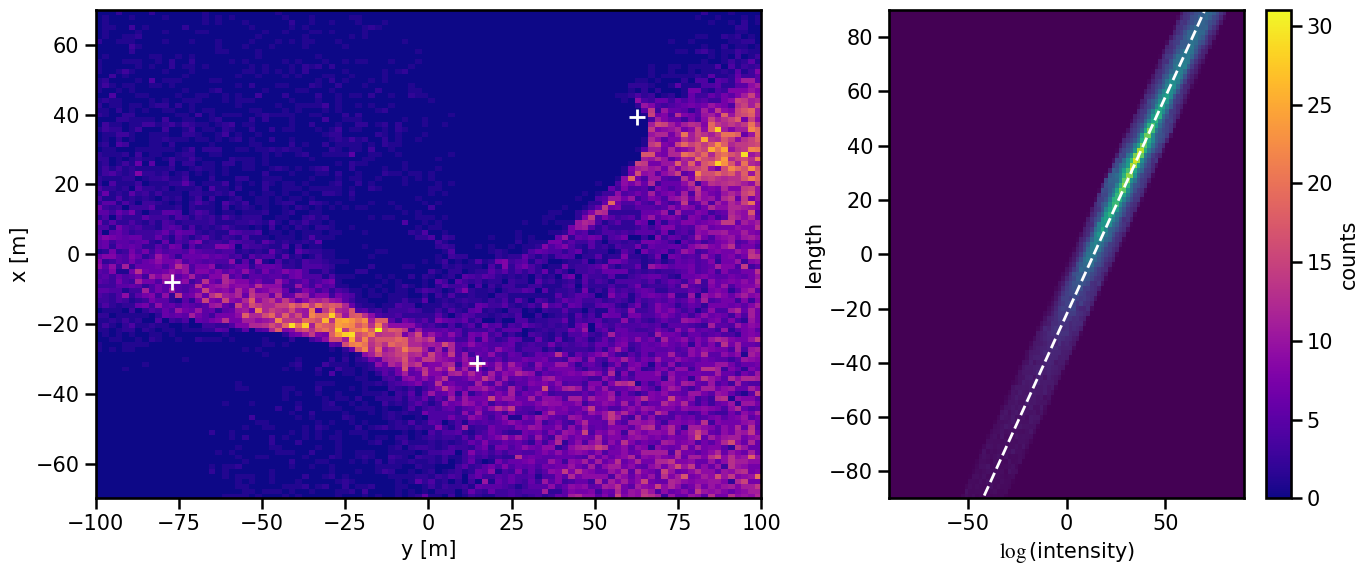

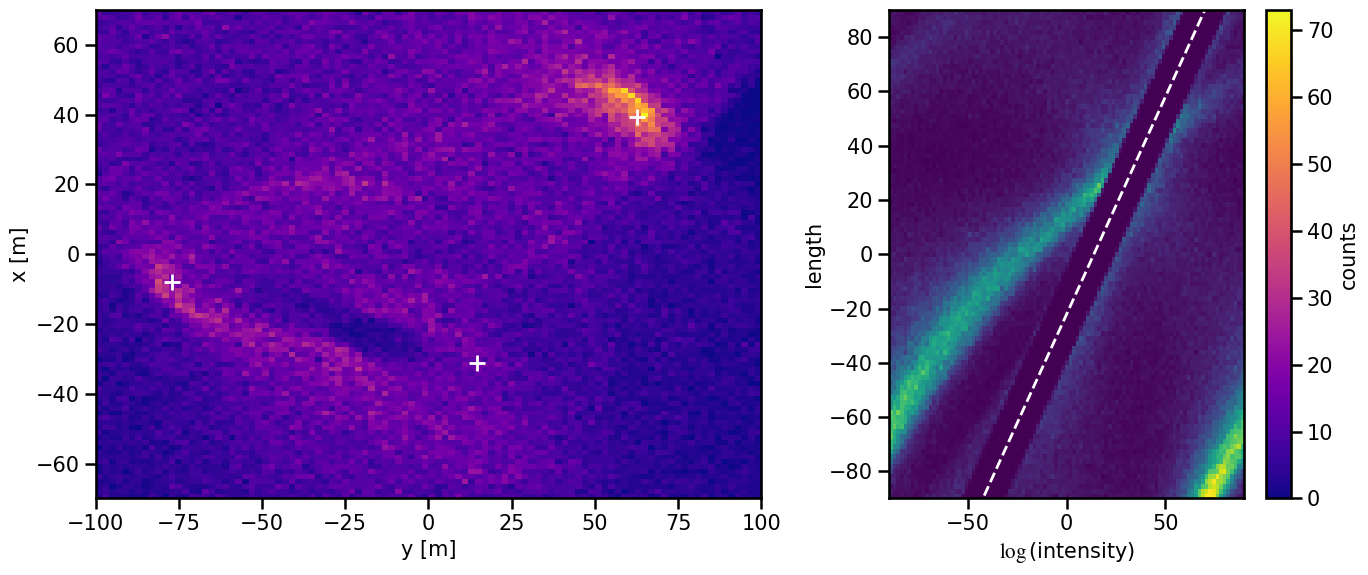

In [16]:
# binning
bins_x = np.linspace(-90, 90, 100)
bins_y = np.linspace(-90, 90, 100)
bins   = (bins_x, bins_y)
xlims = (-100, 100)
ylims = (-70, 70)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6), gridspec_kw={'width_ratios': [1.5, 1]})

for i in range(len(xpos)):
    ax1.plot(xpos[i], ypos[i], '+', color='w', ms=12)

_, _, _, im = ax1.hist2d(df_within['core_x'], df_within['core_y'], bins=100, range=[xlims, ylims],
                         cmap='plasma')
fig.colorbar(im, label='counts', ax=ax2)

_, _, _, im = ax2.hist2d(df_within[f'x'], df_within[f'y'],
                        bins=bins, cmap='viridis')


ax1.set_xlim(*xlims)
ax1.set_ylim(*ylims)
ax1.set_xlabel('y [m]')
ax1.set_ylabel('x [m]')
ax2.set_xlabel('$\log$(intensity)')
ax2.set_ylabel('length')
ax2.plot(bins_x, line(bins_x, 1.6, -22), c='w', ls='--', lw=2)
ax2.set_facecolor((40/255, 125/255, 90/255))
fig.tight_layout()
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6), gridspec_kw={'width_ratios': [1.5, 1]})

for i in range(len(xpos)):
    ax1.plot(xpos[i], ypos[i], '+', color='w', ms=12)

_, _, _, im = ax1.hist2d(df_outside['core_x'], df_outside['core_y'], bins=100, range=[xlims, ylims],
                         cmap='plasma')
fig.colorbar(im, label='counts', ax=ax2)

_, _, _, im = ax2.hist2d(df_outside[f'x'], df_outside[f'y'],
                        bins=bins, cmap='viridis')

ax1.set_xlim(*xlims)
ax1.set_ylim(*ylims)
ax1.set_xlabel('y [m]')
ax1.set_ylabel('x [m]')
ax2.set_xlabel('$\log$(intensity)')
ax2.set_ylabel('length')
ax2.plot(bins_x, line(bins_x, 1.6, -22), c='w', ls='--', lw=2)
ax2.set_facecolor((40/255, 125/255, 90/255))
fig.tight_layout()
plt.show()

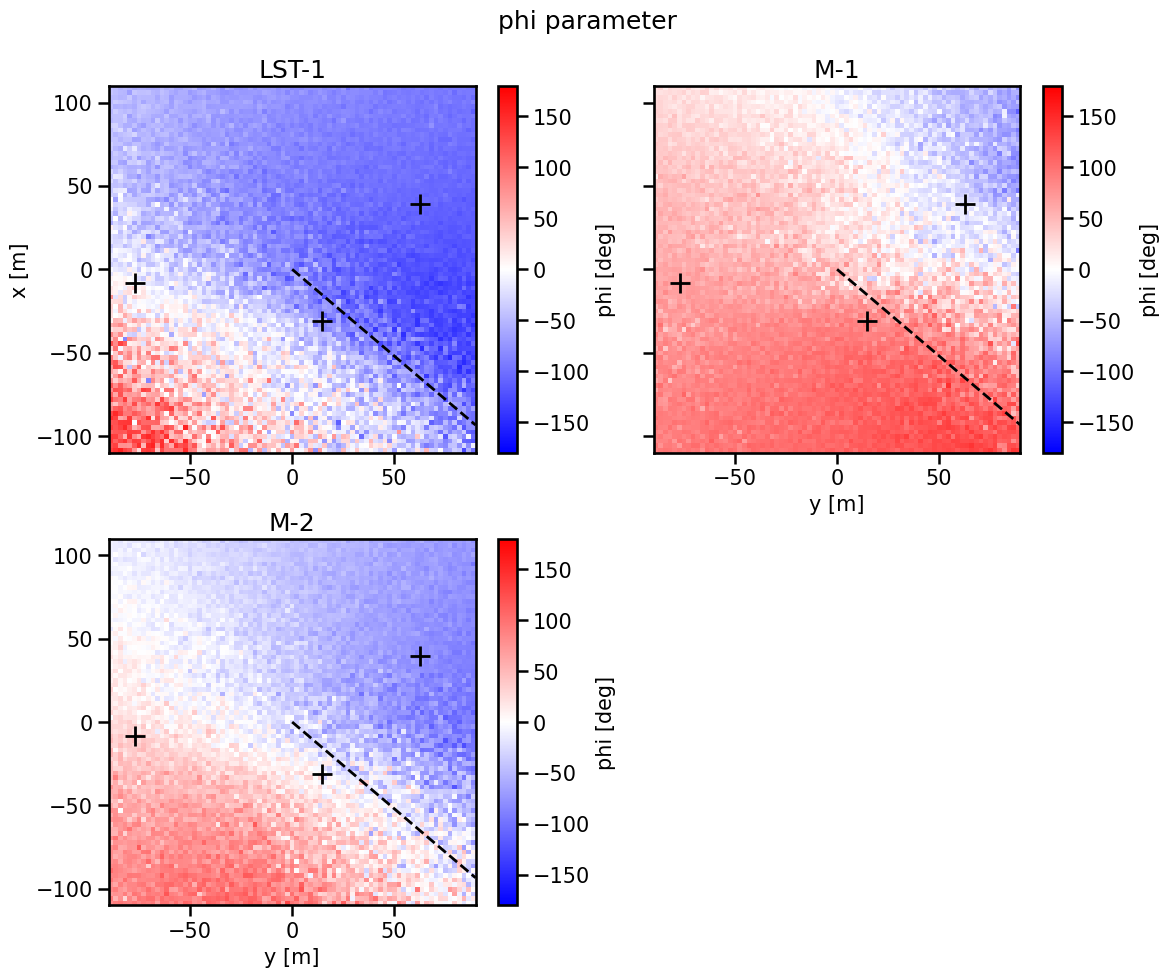

In [17]:
# --- binning the data in positions --- #
ylim  = (-110, 110)
xlim  = (-90,   90)

Nbins = 80
bins_x = np.linspace(*xlim, Nbins)
bins_y = np.linspace(*ylim, Nbins)
bins   = (bins_x, bins_y)
bins_x_center = (bins_x[:-1] + bins_x[1:]) / 2
bins_y_center = (bins_y[:-1] + bins_y[1:]) / 2

tcore_set  = [df['true_core_x'], df['true_core_y']]
core_set   = [df['core_x'], df['core_y']]

binned_1  = binned_statistic_2d(*core_set, df[f'phi'],   bins=bins)[0].T
binned_2  = binned_statistic_2d(*core_set, dfT2[f'phi'], bins=bins)[0].T
binned_3  = binned_statistic_2d(*core_set, dfT3[f'phi'], bins=bins)[0].T


fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10), sharey=True)
fig.suptitle('phi parameter')

# plot the binned data
absmax = 180
cmesh = ax1.pcolormesh(bins_x_center, bins_y_center, binned_1, cmap='bwr', vmax=absmax, vmin=-absmax)
fig.colorbar(cmesh, ax=ax1, label='phi [deg]')

absmax = 180
cmesh = ax2.pcolormesh(bins_x_center, bins_y_center, binned_2, cmap='bwr', vmax=absmax, vmin=-absmax)
fig.colorbar(cmesh, ax=ax2, label='phi [deg]')

absmax = 180
cmesh = ax3.pcolormesh(bins_x_center, bins_y_center, binned_3, cmap='bwr', vmax=absmax, vmin=-absmax)
fig.colorbar(cmesh, ax=ax3, label='phi [deg]')

#######################################
# --- plotting the direction line --- #
#######################################
init_lower = ref_lower[:-1]
init_upper = ref_upper[:-1]

# calculating projection of direction
ref_point = [np.cos(np.deg2rad(point_zd)) * np.sin(np.deg2rad(point_eq_angle)), np.sin(np.deg2rad(point_zd)) * np.sin(np.deg2rad(point_eq_angle)), np.cos(np.deg2rad(point_eq_angle))]
proj_ref = geom.plane_projection(ref_lower, point_dir, *ref_point, *point_dir)

projected_dir = np.rad2deg(np.arctan2(proj_ref[1], proj_ref[0]))

for ax in [ax1, ax2, ax3]:
    ax.plot(*geom.line_in_direction(point_eq_angle, init_lower, ax), ls='--', lw=2, c='k')
#######################################


for ax, t in zip([ax1, ax2, ax3],  ['LST-1', 'M-1', 'M-2']):
    ax.set_title(t)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.plot(xpos, ypos, ls='', c='k', marker='+', ms=15, lw=20) 
    
ax3.set_xlabel('y [m]')
ax2.set_xlabel('y [m]')
ax1.set_ylabel('x [m]')
fig.delaxes(ax4)

fig.tight_layout()
plt.show()

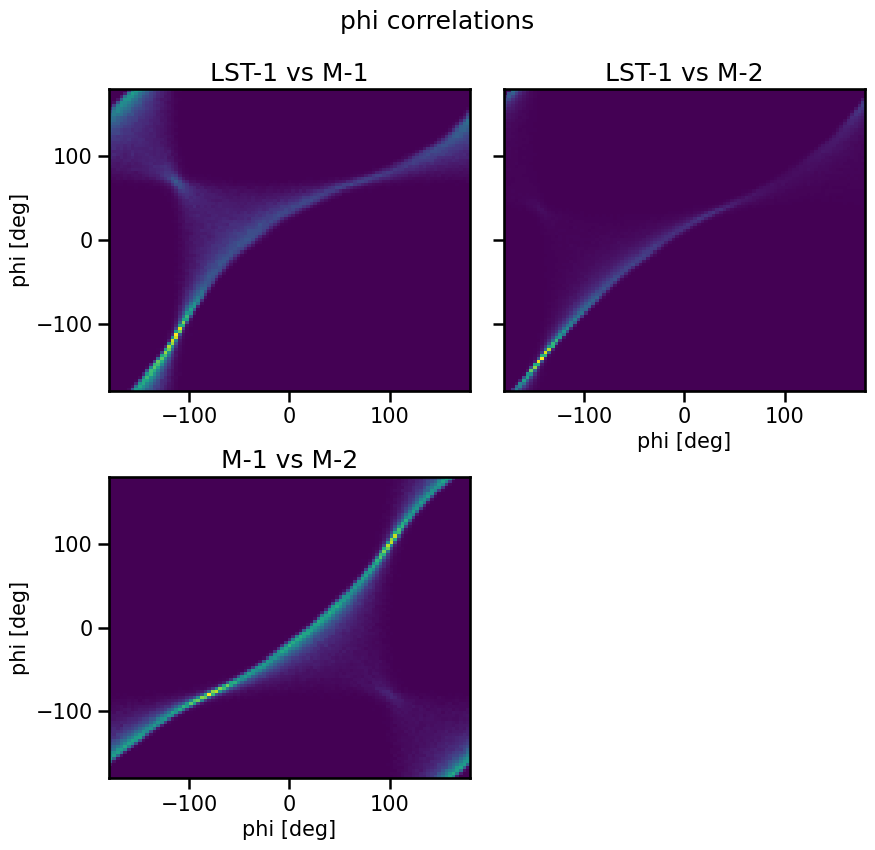

In [18]:
bins_x = np.linspace(-180, 180, 100)
bins_y = np.linspace(-180, 180, 100)
bins   = (bins_x, bins_y)

fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 8.7), sharey=True)
fig.suptitle('phi correlations')

ax1.hist2d(df[f'phi'], dfT2[f'phi'], bins=bins)
ax1.set_title(f'LST-1 vs M-1')

ax2.hist2d(df[f'phi'], dfT3[f'phi'], bins=bins)
ax2.set_title(f'LST-1 vs M-2')

ax3.hist2d(dfT2[f'phi'], dfT3[f'phi'], bins=bins)
ax3.set_title(f'M-1 vs M-2')

ax2.set_xlabel(f'phi [deg]')
ax3.set_xlabel(f'phi [deg]')
ax1.set_ylabel(f'phi [deg]')
ax3.set_ylabel(f'phi [deg]')
fig.delaxes(ax4)

fig.tight_layout()
plt.show()